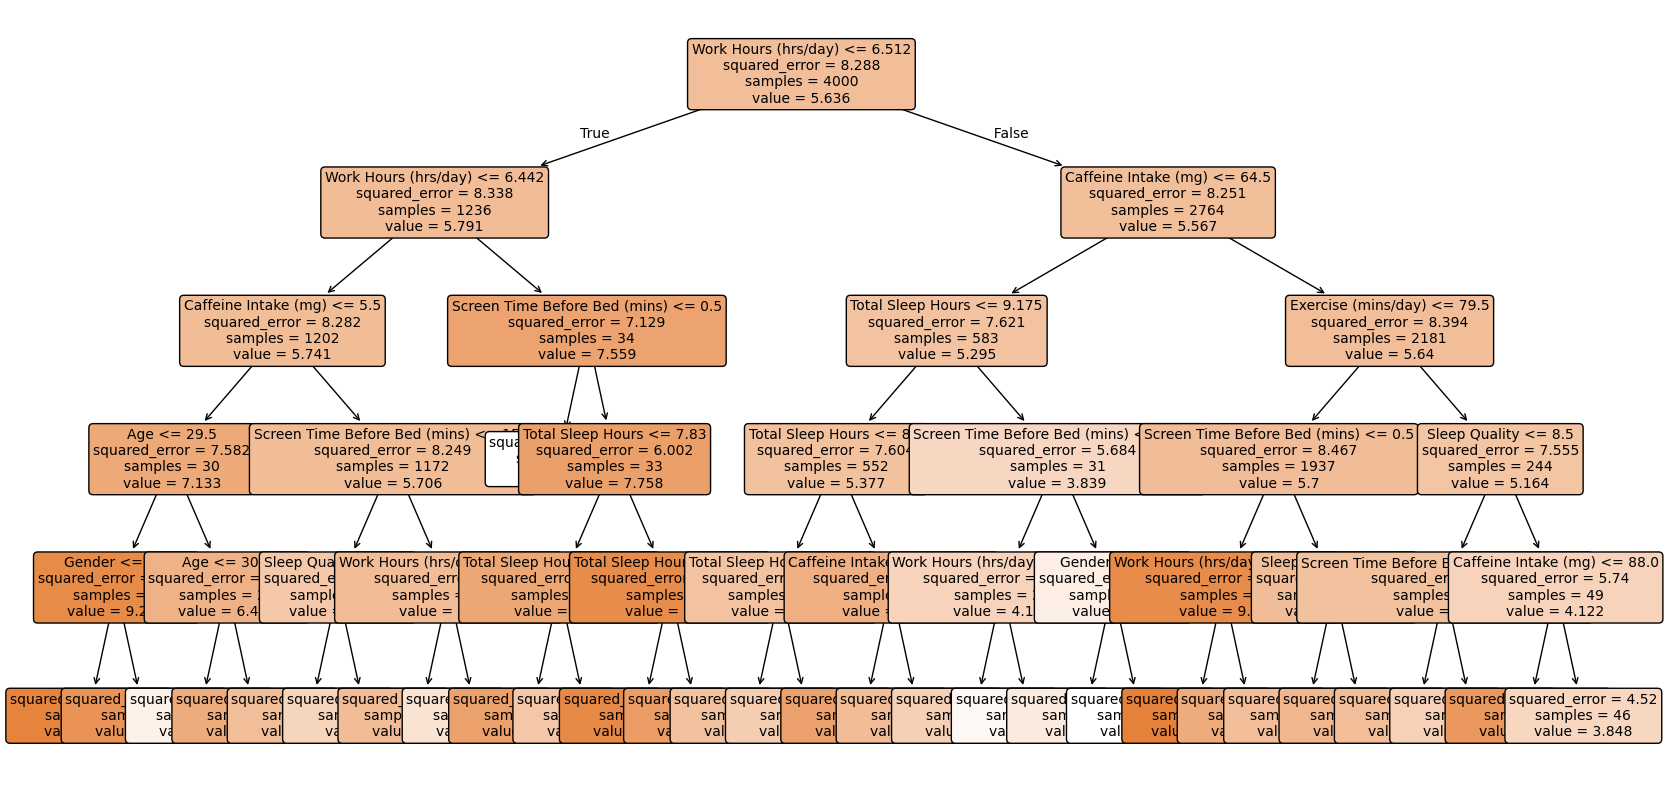

|--- Work Hours (hrs/day) <= 6.51
|   |--- Work Hours (hrs/day) <= 6.44
|   |   |--- Caffeine Intake (mg) <= 5.50
|   |   |   |--- Age <= 29.50
|   |   |   |   |--- Gender <= 1.50
|   |   |   |   |   |--- value: [9.75]
|   |   |   |   |--- Gender >  1.50
|   |   |   |   |   |--- value: [8.67]
|   |   |   |--- Age >  29.50
|   |   |   |   |--- Age <= 30.50
|   |   |   |   |   |--- value: [2.00]
|   |   |   |   |--- Age >  30.50
|   |   |   |   |   |--- value: [6.90]
|   |   |--- Caffeine Intake (mg) >  5.50
|   |   |   |--- Screen Time Before Bed (mins) <= 15.50
|   |   |   |   |--- Sleep Quality <= 6.50
|   |   |   |   |   |--- value: [5.63]
|   |   |   |   |--- Sleep Quality >  6.50
|   |   |   |   |   |--- value: [4.00]
|   |   |   |--- Screen Time Before Bed (mins) >  15.50
|   |   |   |   |--- Work Hours (hrs/day) <= 6.43
|   |   |   |   |   |--- value: [5.78]
|   |   |   |   |--- Work Hours (hrs/day) >  6.43
|   |   |   |   |   |--- value: [3.00]
|   |--- Work Hours (hrs/day) >  6

In [7]:
#method 1--Decision trees
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# load the dataset
df = pd.read_csv("sleep_cycle_productivity.csv")

# delete non-numeric and irrelevant columns
df = df.drop(columns=["Date", "Person_ID"])
df = df.drop(columns=["Sleep Start Time", "Sleep End Time","Mood Score","Stress Level"])

# dealing with gender
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])

# define the target variables
X = df.drop(columns=["Productivity Score"])
y = df["Productivity Score"]

# split training and testing dataset into 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# train the decision tree regressor
dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# visualization
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()

# output the rule 
print(export_text(dt, feature_names=list(X.columns)))

# calculate the importance of each feature
feature_importance = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n importance:")
print(feature_importance)

y_pred = dt.predict(X_test)

# calculate r2
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

In [8]:
#method2--random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importance (Random Forest):\n", feature_importance)

y_pred = rf.predict(X_test)

# calculate r2
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

Feature Importance (Random Forest):
 Work Hours (hrs/day)             0.169454
Total Sleep Hours                0.160401
Caffeine Intake (mg)             0.152979
Screen Time Before Bed (mins)    0.149000
Exercise (mins/day)              0.137229
Age                              0.119702
Sleep Quality                    0.078268
Gender                           0.032967
dtype: float64
R²: -0.030425351860427163


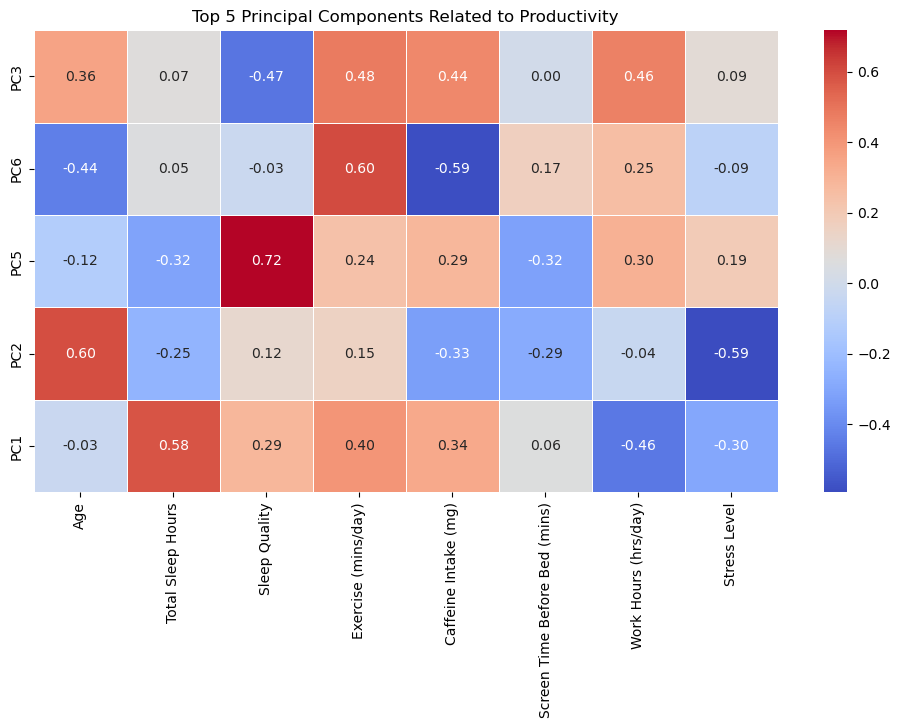

each component explanation of the variance: [0.1319553  0.12960023 0.12691795 0.12523794 0.12405103 0.12237709
 0.12075735 0.1191031 ]
accumulate explanation of the variance(R²): [0.1319553  0.26155553 0.38847349 0.51371143 0.63776246 0.76013955
 0.8808969  1.        ]


In [13]:
# method 3 --PCA multiple factors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# loading dataset
file_path = "sleep_cycle_productivity.csv"  
df = pd.read_csv(file_path)

# choosing numeric variables
numeric_columns = [
    "Age", "Total Sleep Hours", "Sleep Quality",
    "Exercise (mins/day)", "Caffeine Intake (mg)", "Screen Time Before Bed (mins)",
    "Work Hours (hrs/day)", "Stress Level"
]

# take numeric data
data_numeric = df[numeric_columns]
productivity_score = df["Productivity Score"]

# standardlize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# load PCA model
pca = PCA(n_components=len(numeric_columns))  
pca.fit(data_scaled)
loadings = pca.components_

# calculating relevance
principal_components = pca.transform(data_scaled)  
pc_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(len(numeric_columns))])
pc_df["Productivity Score"] = productivity_score
correlations = pc_df.corr()["Productivity Score"].abs().sort_values(ascending=False)
top_5_pcs = [pc for pc in correlations.index if pc.startswith("PC")][:5]  # Only choose top 5

# draw heatmap
top_5_loadings = pd.DataFrame(loadings[:len(numeric_columns)], columns=numeric_columns, index=[f'PC{i+1}' for i in range(len(numeric_columns))])

plt.figure(figsize=(12, 6))
sns.heatmap(top_5_loadings.loc[top_5_pcs], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Top 5 Principal Components Related to Productivity")
plt.show()


X_scaled = scaler.fit_transform(X)

# PCA model
pca = PCA()
pca.fit(X_scaled)


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f"each component explanation of the variance: {explained_variance_ratio}")
print(f"accumulate explanation of the variance(R²): {cumulative_explained_variance}")